In [2]:
install.packages(c('caret', 'randomForest', 'caretEnsemble', 'kernlab', 'ranger'))

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘listenv’, ‘parallelly’, ‘future’, ‘globals’, ‘future.apply’, ‘progressr’, ‘numDeriv’, ‘SQUAREM’, ‘lava’, ‘prodlim’, ‘proxy’, ‘iterators’, ‘gower’, ‘ipred’, ‘timeDate’, ‘e1071’, ‘foreach’, ‘ModelMetrics’, ‘plyr’, ‘pROC’, ‘recipes’, ‘reshape2’, ‘pbapply’, ‘gridExtra’, ‘RcppEigen’




In [3]:
library(data.table)
library(caret)
library(randomForest)
library(tidyverse)
library(caretEnsemble)
library(kernlab)
library(e1071)
library(ranger)

Loading required package: ggplot2

Loading required package: lattice

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:ggplot2’:

    margin


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ tibble  3.1.5     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.0.2     ✔ forcats 0.5.1
✔ purrr   0.3.4     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()       masks data.table::between()
✖ dplyr::combine()       masks randomForest::combine()
✖ dplyr::filter()        masks stats::filter()
✖ dplyr::first()         masks data.table::first()
✖ dplyr::lag()           masks stats::lag()
✖ dplyr::last()          masks data.table::last()
✖ purrr::lift()          masks caret::lift()
✖ randomF

#Retrieve Pre-Processed Data
* Retrieve previously cleaned data

In [10]:
#File manually uploaded on google colab.
flats_full = fread('../content/flats_processed_ 2021-10-27.csv')
tail(flats_full)

town,storey_range,floor_area_sqm,flat_model,resale_price,transaction_year,transaction_mth,remaining_year,remaining_month
<chr>,<chr>,<dbl>,<chr>,<dbl>,<int>,<int>,<int>,<int>
YISHUN,04 TO 06,112,Improved,525000,2021,8,92,8
YISHUN,10 TO 12,126,Improved,550000,2021,8,62,11
YISHUN,04 TO 06,122,Improved,500000,2021,8,65,7
YISHUN,04 TO 06,142,Apartment,648000,2021,8,65,11
YISHUN,04 TO 06,146,Maisonette,620000,2021,8,63,1
YISHUN,01 TO 03,145,Apartment,595000,2021,8,63,10


#Further Feature and Data Processing
* Encoding (one-hot or categorical)
* Train-test split
* Scaling

In [11]:
#Split data into training and test 
set.seed(100)
training_set_rows = createDataPartition(flats_full$resale_price, p=0.75, list=FALSE)
training_set = flats_full[training_set_rows]
test_set = flats_full[-training_set_rows]

In [12]:
#Label encode others non-numerical
training_set[, c("town", "flat_model", "storey_range")] = lapply(training_set[, c("town", "flat_model", "storey_range")], factor)
test_set[, c("town", "flat_model", "storey_range")] = lapply(test_set[, c("town", "flat_model", "storey_range")], factor)
training_set$storey_range = as.numeric(training_set$storey_range)
test_set$storey_range = as.numeric(test_set$storey_range)

In [13]:
#X and y split for training and test set
training_set_X = training_set[, !names(training_set) %in% c("resale_price"), with = FALSE]
training_set_y = training_set[, "resale_price"]
test_set_X = test_set[, !names(test_set) %in% c("resale_price"), with=FALSE]
test_set_y = test_set[, "resale_price"]

In [14]:
#Scale data to between range of 0 and 1
scaler = preProcess(training_set_X, method='range')
training_set_X = predict(scaler, newdata=training_set_X)
test_set_X = predict(scaler, newdata=test_set_X)

In [15]:
str(training_set_y)

Classes ‘data.table’ and 'data.frame':	78534 obs. of  1 variable:
 $ resale_price: num  232000 250000 262000 265000 280000 ...
 - attr(*, ".internal.selfref")=<externalptr> 


In [16]:
str(training_set_X)

Classes ‘data.table’ and 'data.frame':	78534 obs. of  8 variables:
 $ town            : Factor w/ 26 levels "ANG MO KIO","BEDOK",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ storey_range    : num  0.1875 0 0 0.0625 0.0625 ...
 $ floor_area_sqm  : num  0.0596 0.1651 0.1651 0.1697 0.1697 ...
 $ flat_model      : Factor w/ 20 levels "2-room","Adjoined flat",..: 5 12 12 12 12 12 12 12 12 12 ...
 $ transaction_year: num  0 0 0 0 0 0 0 0 0 0 ...
 $ transaction_mth : num  0 0 0 0 0 0 0 0 0 0 ...
 $ remaining_year  : num  0.629 0.619 0.639 0.639 0.629 ...
 $ remaining_month : num  0.3636 0.6364 0.4545 0.0909 0.5455 ...
 - attr(*, ".internal.selfref")=<externalptr> 


#Feature Selection
* Evaluate which features are more important
* Decide if features to remain or be dropped

In [8]:
#Set up algorithm and its parameters
#Use rfFuncs with 2-fold cross validation (Unable to increase validation folds or do repeat CV due to system limitation.)
selection_algo = rfeControl(functions = rfFuncs, 
                                method = "cv", 
                                verbose = TRUE,
                                number = 2)

In [9]:
#Feature selection using backward stepwise selection with rfe function
subset = c(1:5)
selection_details = rfe(x=training_set_X, 
                        y=as.matrix(training_set_y),
                        sizes = subset,
                        rfeControl = selection_algo)

+(rfe) fit Fold1 size: 8 
-(rfe) fit Fold1 size: 8 
+(rfe) imp Fold1 
-(rfe) imp Fold1 
+(rfe) fit Fold1 size: 5 
-(rfe) fit Fold1 size: 5 
+(rfe) fit Fold1 size: 4 
-(rfe) fit Fold1 size: 4 
+(rfe) fit Fold1 size: 3 
-(rfe) fit Fold1 size: 3 
+(rfe) fit Fold1 size: 2 
-(rfe) fit Fold1 size: 2 
+(rfe) fit Fold1 size: 1 
-(rfe) fit Fold1 size: 1 
+(rfe) fit Fold2 size: 8 
-(rfe) fit Fold2 size: 8 
+(rfe) imp Fold2 
-(rfe) imp Fold2 
+(rfe) fit Fold2 size: 5 
-(rfe) fit Fold2 size: 5 
+(rfe) fit Fold2 size: 4 
-(rfe) fit Fold2 size: 4 
+(rfe) fit Fold2 size: 3 
-(rfe) fit Fold2 size: 3 
+(rfe) fit Fold2 size: 2 
-(rfe) fit Fold2 size: 2 
+(rfe) fit Fold2 size: 1 
-(rfe) fit Fold2 size: 1 


Warning message in rfout$mse/(var(y) * (n - 1)/n):
“Recycling array of length 1 in vector-array arithmetic is deprecated.
  Use c() or as.vector() instead.
”


In [10]:
#See results of each subset applied
selection_details


Recursive feature selection

Outer resampling method: Cross-Validated (2 fold) 

Resampling performance over subset size:

 Variables   RMSE Rsquared    MAE  RMSESD RsquaredSD   MAESD Selected
         1 143729   0.1561 110797  180.24  0.0047093   54.63         
         2  65539   0.8273  46521   30.98  0.0011984  205.59         
         3  77247   0.7857  55791  208.56  0.0023862  275.92         
         4  70728   0.8270  51633  557.89  0.0000223  292.45         
         5  57419   0.8941  42354 1433.55  0.0143489 1117.55         
         8  39342   0.9393  27936   58.48  0.0011536   14.03        *

The top 5 variables (out of 8):
   town, floor_area_sqm, transaction_year, storey_range, flat_model


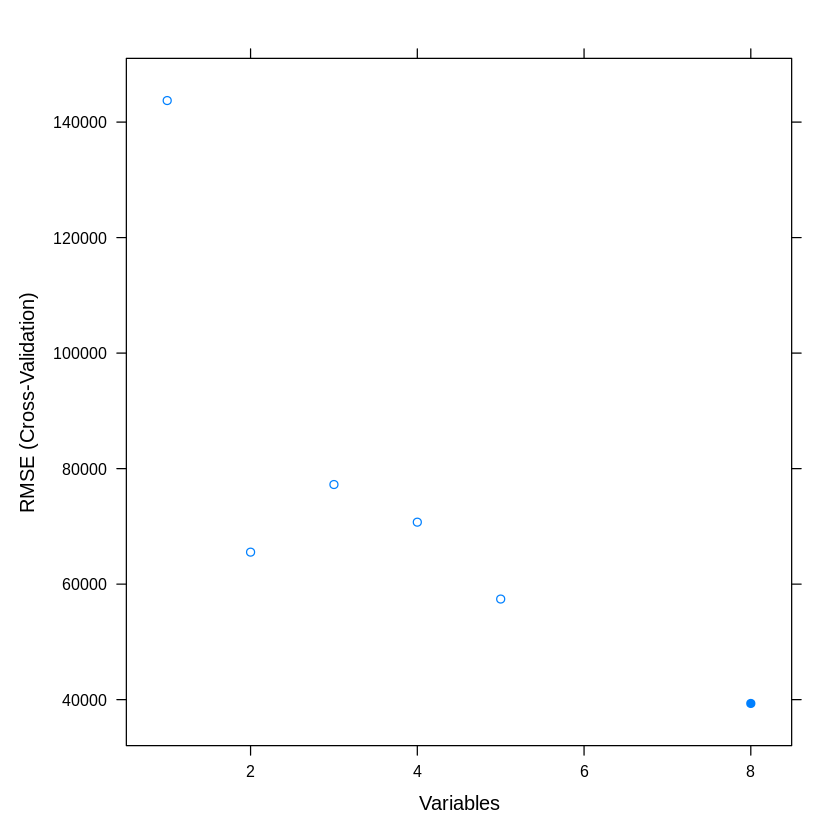

In [11]:
#plot result to visually see performance
plot(selection_details)

In [12]:
#See variables ranked by importance
predictors(selection_details)

[1] "town"             "floor_area_sqm"   "transaction_year" "storey_range"    
[5] "flat_model"       "remaining_year"   "transaction_mth"  "remaining_month"

**Analysis**
* Lowest RMSE was obtained when all 8 variables were used.
* Ideally, if system specs permits, we could refit the rfe models, increasing to 10-fold cv and including 6 and 7 variables to test for. 
* We expect that the 8th variable ("transaction month") would have little impact on the performance.
* However, given that we are unable to rerun the model due to system limitation, we will keep all the variables per the results obtained above.

#Model Fitting and Tuning
* Fit various models to the data
* Tune model parameters
* Selection model with best performance

In [ ]:
#Set standard of training for all models
#All models to carry out 10-fold CV repeated 5 times
set.seed(100)
trainCtrl <- trainControl( method = "repeatedcv",
                           number = 10,
                           p = 0.75,
                           verboseIter = TRUE,
                           repeats = 3,
                           savePredictions="final",
                           index=createResample(training_set_y$resale_price, 10)
                           )

In [ ]:
# #Prohibitive long to run. Not executed.
# #Model ran individually.
# #Create list of models to be trained
# algoList <- caretList(
#   x=training_set_X_onehot,
#   y=training_set_y$resale_price,
#   trControl=trainCtrl,
#   methodList=c("knn", "svmRadial", "rf"),
#   metric = "RMSE")

In [ ]:
modelLookup("rf")

,model,parameter,label,forReg,forClass,probModel
,<chr>,<chr>,<chr>,<lgl>,<lgl>,<lgl>
1,rf,mtry,#Randomly Selected Predictors,TRUE,TRUE,TRUE


In [ ]:
#Fitting with random forest algorithm
set.seed(100)
rfFit <- train(x=training_set_X, 
               y=training_set_y$resale_price, 
               method = "ranger", 
               trControl = trainCtrl,
               verbose = TRUE,
               tuneLength=3)

+ Resample01: mtry=2, min.node.size=5, splitrule=variance 
- Resample01: mtry=2, min.node.size=5, splitrule=variance 
+ Resample01: mtry=3, min.node.size=5, splitrule=variance 
Growing trees.. Progress: 84%. Estimated remaining time: 5 seconds.
- Resample01: mtry=3, min.node.size=5, splitrule=variance 
+ Resample01: mtry=5, min.node.size=5, splitrule=variance 
Growing trees.. Progress: 59%. Estimated remaining time: 21 seconds.
- Resample01: mtry=5, min.node.size=5, splitrule=variance 
+ Resample01: mtry=6, min.node.size=5, splitrule=variance 
Growing trees.. Progress: 52%. Estimated remaining time: 28 seconds.
- Resample01: mtry=6, min.node.size=5, splitrule=variance 
+ Resample01: mtry=8, min.node.size=5, splitrule=variance 
Growing trees.. Progress: 42%. Estimated remaining time: 42 seconds.
Growing trees.. Progress: 85%. Estimated remaining time: 11 seconds.
- Resample01: mtry=8, min.node.size=5, splitrule=variance 
+ Resample01: mtry=2, min.node.size=5, splitrule=extratrees 
Growi

In [ ]:
rfFit

Random Forest 

74610 samples
    8 predictor

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 5 times) 
Summary of sample sizes: 74610, 74610, 74610, 74610, 74610, 74610, ... 
Resampling results across tuning parameters:

  mtry  splitrule   RMSE      Rsquared   MAE     
  2     variance    51455.53  0.8964869  35015.09
  2     extratrees  53636.74  0.8983214  38017.50
  3     variance    44419.19  0.9215175  30268.96
  3     extratrees  46033.52  0.9198806  32198.63
  5     variance    39571.32  0.9369392  27250.81
  5     extratrees  40911.64  0.9343040  28642.22
  6     variance    38970.44  0.9386750  26857.31
  6     extratrees  39502.19  0.9381939  27692.41
  8     variance    39769.25  0.9359851  27129.55
  8     extratrees  37932.89  0.9423895  26622.80

Tuning parameter 'min.node.size' was held constant at a value of 5
RMSE was used to select the optimal model using the smallest value.
The final values used for the model were mtry = 8, splitrule = extratrees


In [ ]:
modelLookup("knn")

,model,parameter,label,forReg,forClass,probModel
,<chr>,<chr>,<chr>,<lgl>,<lgl>,<lgl>
1,knn,k,#Neighbors,TRUE,TRUE,TRUE


In [8]:
#One-hot encode non-ordinal categorical variables
dummy_encoder = dummyVars(~ ., data=training_set_X)
training_set_X_onehot = predict(dummy_encoder, newdata=training_set_X)
test_set_X_onehot = predict(dummy_encoder, newdata=test_set_X)

In [ ]:
#Fitting with knn algorithm
set.seed(100)
knnFit <- train(x=training_set_X_onehot, 
               y=training_set_y$resale_price, 
               method = "knn", 
               trControl = trainCtrl,
               verbose = TRUE,
               tuneLength=5)

+ Resample01: k= 5 
- Resample01: k= 5 
+ Resample01: k= 7 
- Resample01: k= 7 
+ Resample01: k= 9 
- Resample01: k= 9 
+ Resample01: k=11 
- Resample01: k=11 
+ Resample01: k=13 
- Resample01: k=13 
+ Resample02: k= 5 
- Resample02: k= 5 
+ Resample02: k= 7 
- Resample02: k= 7 
+ Resample02: k= 9 
- Resample02: k= 9 
+ Resample02: k=11 
- Resample02: k=11 
+ Resample02: k=13 
- Resample02: k=13 
+ Resample03: k= 5 
- Resample03: k= 5 
+ Resample03: k= 7 
- Resample03: k= 7 
+ Resample03: k= 9 
- Resample03: k= 9 
+ Resample03: k=11 
- Resample03: k=11 
+ Resample03: k=13 
- Resample03: k=13 
+ Resample04: k= 5 
- Resample04: k= 5 
+ Resample04: k= 7 
- Resample04: k= 7 
+ Resample04: k= 9 
- Resample04: k= 9 
+ Resample04: k=11 
- Resample04: k=11 
+ Resample04: k=13 
- Resample04: k=13 
+ Resample05: k= 5 
- Resample05: k= 5 
+ Resample05: k= 7 
- Resample05: k= 7 
+ Resample05: k= 9 
- Resample05: k= 9 
+ Resample05: k=11 
- Resample05: k=11 
+ Resample05: k=13 
- Resample05: k=13 


In [ ]:
knnFit

k-Nearest Neighbors 

74610 samples
   52 predictor

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 5 times) 
Summary of sample sizes: 74610, 74610, 74610, 74610, 74610, 74610, ... 
Resampling results across tuning parameters:

  k   RMSE      Rsquared   MAE     
   5  65717.47  0.8258125  46611.90
   7  65471.63  0.8266032  46840.59
   9  65689.26  0.8253379  47294.18
  11  66195.25  0.8226845  47816.55
  13  66823.78  0.8194165  48361.27

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was k = 7.

In [ ]:
modelLookup("svmRadial")

,model,parameter,label,forReg,forClass,probModel
,<chr>,<chr>,<chr>,<lgl>,<lgl>,<lgl>
1,svmRadial,sigma,Sigma,TRUE,TRUE,TRUE
2,svmRadial,C,Cost,TRUE,TRUE,TRUE


In [ ]:
# #Prohibitive long to run. Not executed.
# #Fitting with svmRadial algorithm
# set.seed(100)
# svmFit <- train(x=training_set_X_onehot, 
#                y=training_set_y$resale_price, 
#                method = "svmRadial", 
#                trControl = trainCtrl,
#                verbose = TRUE,
#                tuneLength=5)

**Analysis**
* The random forest model outperformed the knn model with a lower RMSE with the same training control metrics.
* The svmRadial model was not able to complete within the allowed runtime on google collab.
* The random forest is selected for further optimisation of the hyperparameters.

#Hyper-parameter Tuning - Grid Search
* Tuning of the number of features at each split(mtry) and the minimum size of each node(min.node.size) for the random forest model

In [10]:
set.seed(100)
tuneCtrl <- trainControl( method = "repeatedcv",
                           number = 10,
                           p = 0.75,
                           verboseIter = TRUE,
                           repeats = 3,
                           savePredictions="final",
                           index=createResample(training_set_y$resale_price, 10)
                           )

In [11]:
rfGrid = expand.grid(mtry=seq(4,8,1), splitrule="variance", min.node.size=seq(5,13,2))

In [ ]:
#Apply tune grid and fit best model above
set.seed(100)
rfTuned = train(x=training_set_X,
  y=training_set_y$resale_price,
  method="ranger",
  tuneGrid=rfGrid,
  trControl=tuneCtrl)

+ Resample01: mtry=4, splitrule=variance, min.node.size= 5 
Growing trees.. Progress: 67%. Estimated remaining time: 14 seconds.
- Resample01: mtry=4, splitrule=variance, min.node.size= 5 
+ Resample01: mtry=5, splitrule=variance, min.node.size= 5 
Growing trees.. Progress: 56%. Estimated remaining time: 24 seconds.
- Resample01: mtry=5, splitrule=variance, min.node.size= 5 
+ Resample01: mtry=6, splitrule=variance, min.node.size= 5 
Growing trees.. Progress: 53%. Estimated remaining time: 27 seconds.
- Resample01: mtry=6, splitrule=variance, min.node.size= 5 
+ Resample01: mtry=7, splitrule=variance, min.node.size= 5 
Growing trees.. Progress: 46%. Estimated remaining time: 36 seconds.
Growing trees.. Progress: 90%. Estimated remaining time: 6 seconds.
- Resample01: mtry=7, splitrule=variance, min.node.size= 5 
+ Resample01: mtry=8, splitrule=variance, min.node.size= 5 
Growing trees.. Progress: 44%. Estimated remaining time: 39 seconds.
Growing trees.. Progress: 88%. Estimated remain

In [ ]:
rfTuned

Random Forest 

74610 samples
    8 predictor

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 74610, 74610, 74610, 74610, 74610, 74610, ... 
Resampling results across tuning parameters:

  mtry  min.node.size  RMSE      Rsquared   MAE     
  4      5             41161.09  0.9320943  28243.79
  4      7             41233.74  0.9318950  28316.78
  4      9             41378.34  0.9314463  28417.71
  4     11             41538.87  0.9309562  28540.29
  4     13             41702.52  0.9304467  28663.92
  5      5             39587.17  0.9368864  27260.59
  5      7             39612.42  0.9368299  27285.41
  5      9             39706.83  0.9365574  27361.10
  5     11             39808.11  0.9362527  27431.78
  5     13             39965.87  0.9357754  27544.61
  6      5             38981.81  0.9386369  26853.94
  6      7             38993.14  0.9386209  26877.70
  6      9             39054.34  0.9384429  26915.45
  6     11        

**Analysis**
* Optimum minimum node size is 5
* Optimum number of features at each split is 6
* Split rule kept at "variance"

#Best Model Prediction
* Rerun model with randomForest function as runtime disconnects frequently
* Sets model parameters to optimum 
* Predicts test set

In [10]:
rfRegressor = randomForest(x=training_set_X, y=training_set_y$resale_price,
             mtry=6,
             nodesize = 5,
             )

In [11]:
best_model_pred <- rfRegressor %>% predict(test_set_X)
data.frame(
  RMSE = RMSE(best_model_pred, test_set_y$resale_price),
  R2 = R2(best_model_pred, test_set_y$resale_price),
  MAE = MAE(best_model_pred, test_set_y$resale_price)
)

RMSE,R2,MAE
<dbl>,<dbl>,<dbl>
33933.4,0.9538315,23880.84


In [19]:
rmse = 33933.4
Precent_error = 100*(rmse/mean(training_set_y$resale_price))
round(Precent_error, 2)

[1] 7.51

#Results
* This model outperformed the ranger grid search model.
* RMSE obtained in this randomForest model is about 5000 lower, at 33933.4.
* Percentage error against the mean resale price is 7.5%.



#Model Finalisation
* Fit full (system permitted maximum) data with optimised parameters
* Save model to be used for future prediction 

In [4]:
#Label encode others non-numerical
flats_full[, c("town", "flat_model", "storey_range")] = lapply(flats_full[, c("town", "flat_model", "storey_range")], factor)
flats_full$storey_range = as.numeric(flats_full$storey_range)

In [5]:
#Scale data to between range of 0 and 1
scaler = preProcess(flats_full, method='range')
flats_scaled = predict(scaler, newdata=flats_full)

In [ ]:
head(flats_scaled)

In [6]:
#Reduce data size to improve system performance
retained_rows = createDataPartition(flats_scaled$resale_price, p=0.85, list=FALSE)
flats_scaled = flats_scaled[retained_rows]

In [ ]:
#Final model to be saved and used for future prediction.
finalRfRegr = randomForest(x=flats_reduced[, -"resale_price"], y=flats_reduced$resale_price, ntree=1000,
             mtry=6,
             nodesize = 5,
             )

#Conclusion
* All features are deemed important and retained after feature selection using rfe().
* Random forest algorithm performed better than knn after 10-fold cross validation.
* Grid search found minimum node size of 5, with 500 trees and minimum split at 6 optimum for the model prediction.
* Model predicted within 7.5% of mean resale price with RMSE of 33933.4.
* Final model to be fitted with full data and used for prediction and valuation. (Final model not run due to system limitation.)